Plotting: fsnet5_steps_viz.pt
Trajectory shape: (8, 2)
Trajectory points:
[[1.         2.        ]
 [0.99166667 1.98333333]
 [0.50000042 1.00000085]
 [0.49999173 0.99998345]
 [0.49909344 0.99225111]
 [0.50131968 0.96347117]
 [0.49736308 0.96184665]
 [0.49721082 0.96329944]]
Step sizes: [1.86338998e-02 1.09939914e+00 1.94485877e-05 7.78435173e-03
 2.88659080e-02 4.27712893e-03 1.46074944e-03]
Saved: fsnet_projection_clean.png / .svg


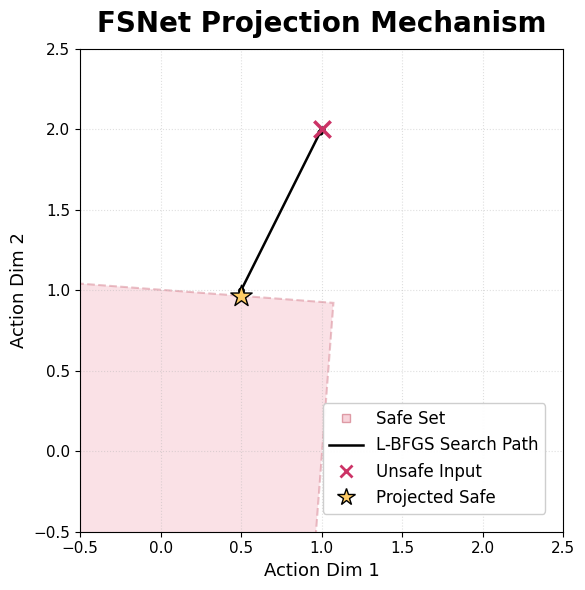

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.lines import Line2D
from scipy.spatial import ConvexHull, HalfspaceIntersection
from scipy.optimize import linprog
from itertools import product
from pathlib import Path

# ==========================================
# 1. Geometry Helpers
# ==========================================

def get_zonotope_polygon(center, generators):
    if isinstance(center, torch.Tensor): center = center.detach().cpu().numpy()
    if isinstance(generators, torch.Tensor): generators = generators.detach().cpu().numpy()
    
    if center.ndim > 1: center = center[0]
    if generators.ndim > 2: generators = generators[0]
    
    c = center.flatten()
    G = generators
    n_gens = G.shape[1]
    
    coeffs = list(product([-1, 1], repeat=n_gens))
    vertices = []
    for coef in coeffs:
        delta = G @ np.array(coef)
        v = c + delta
        vertices.append(v)
    
    vertices = np.array(vertices)
    try:
        hull = ConvexHull(vertices)
        ordered_vertices = vertices[hull.vertices]
        return Polygon(ordered_vertices, closed=True)
    except Exception:
        return None

def get_polytope_polygon(A, b, interior_point=None):
    if isinstance(A, torch.Tensor): A = A.detach().cpu().numpy()
    if isinstance(b, torch.Tensor): b = b.detach().cpu().numpy()

    if A.ndim > 2: A = A[0]
    if b.ndim > 1: b = b[0]
    
    valid_mask = np.isfinite(b)
    A = A[valid_mask]
    b = b[valid_mask]
    
    if len(b) == 0: return None

    if interior_point is None:
        norm_A = np.linalg.norm(A, axis=1)
        c_obj = np.zeros(A.shape[1] + 1)
        c_obj[-1] = -1 
        A_ub = np.hstack([A, norm_A[:, np.newaxis]])
        res = linprog(c_obj, A_ub=A_ub, b_ub=b, bounds=(None, None), method='highs')
        if res.success and res.x[-1] > 1e-6: 
            interior_point = res.x[:-1]
        else:
            interior_point = np.zeros(A.shape[1]) 
    
    halfspaces = np.hstack((A, -b[:, np.newaxis]))

    try:
        hs = HalfspaceIntersection(halfspaces, interior_point)
        vertices = hs.intersections
        hull = ConvexHull(vertices)
        ordered_vertices = vertices[hull.vertices]
        return Polygon(ordered_vertices, closed=True)
    except Exception:
        return None

# ==========================================
# 2. Data Loader
# ==========================================

def load_list_data(filepath):
    path = Path(filepath)
    if not path.exists():
        for p in [Path("../" + path.name), Path(path.name)]:
            if p.exists():
                path = p
                break
        else:
            print(f"File not found: {filepath}")
            return None

    data = torch.load(path, map_location='cpu', weights_only=False)
    if not isinstance(data, list): data = [data]
    return data

# ==========================================
# 3. Plotting Function (FSNet / Clean)
# ==========================================

def plot_fsnet_projection_clean(filepath, step_idx=0, save=True):
    data_list = load_list_data(filepath)
    if not data_list: return

    data = data_list[min(step_idx, len(data_list)-1)]

    traj = data.get('trajectory') 
    unsafe = data.get('unsafe_action')
    
    if traj is None: return

    if traj.ndim == 3: traj = traj[:, 0, :]
    if unsafe.ndim == 2: unsafe = unsafe[0]

    traj = traj.detach().cpu().numpy()
    unsafe = unsafe.detach().cpu().numpy()
    
    # --- Check the trajectory (one shot or iterative)---
    # print(f"Trajectory shape: {traj.shape}")
    # print(f"Trajectory points:\n{traj}")
    
    # # Calculate distances between consecutive points to see if they are distinct
    # dists = np.linalg.norm(traj[1:] - traj[:-1], axis=1)
    # print(f"Step sizes: {dists}")
    # -----------------------------------

    # end = Final projected point
    end = traj[-1]

    # --- Style Config ---
    safe_fill = "#f3b6c2"       # Light Pink
    safe_edge = "#cc6677"       # Darker Pink
    path_color = "black"
    unsafe_color = "#cc3366"    # Magenta/Red
    projected_color = "#ffcc66" # Yellow/Orange

    fig, ax = plt.subplots(figsize=(6, 6))

    # 1. Safe Set
    poly = None
    if "safe_set_center" in data:
        poly = get_zonotope_polygon(data["safe_set_center"], data["safe_set_generators"])
    elif "safe_set_A" in data:
        poly = get_polytope_polygon(data["safe_set_A"], data["safe_set_b"], interior_point=end)

    if poly:
        poly.set_facecolor(safe_fill)
        poly.set_edgecolor(safe_edge)
        poly.set_alpha(0.4)
        poly.set_linewidth(1.5)
        poly.set_linestyle("--")
        ax.add_patch(poly)

    # 2. Solver Trajectory (Black line)
    # Plotting the whole path, but removing the specific 'start' marker
    ax.plot(traj[:, 0], traj[:, 1], "-o", color=path_color, lw=1.8, markersize=3.5)

    # 3. Points (Only Unsafe & Projected, NO Solver Init)
    
    # Unsafe Input (Red X)
    ax.scatter(unsafe[0], unsafe[1], marker="x", c=unsafe_color, s=140, linewidths=2.5, zorder=4)
    
    # Projected Safe (Yellow Star)
    ax.scatter(end[0], end[1], marker="*", c=projected_color, edgecolors="black", s=260, zorder=5)

    # --- Formatting ---
    ax.set_title("FSNet Projection Mechanism", fontsize=20, fontweight="bold", pad=12)
    ax.set_xlabel("Action Dim 1", fontsize=13)
    ax.set_ylabel("Action Dim 2", fontsize=13)
    ax.tick_params(labelsize=11)

    ax.set_aspect("equal")
    ax.set_xlim(-0.5, 2.5)
    ax.set_ylim(-0.5, 2.5)
    ax.grid(True, linestyle=":", alpha=0.4)

    # --- Legend (Removed 'Projection Mapping' & 'Solver Init') ---
    legend_elements = [
        Line2D([0],[0], marker='s', color='w', markerfacecolor=safe_fill, markeredgecolor=safe_edge, alpha=0.6, label='Safe Set'),
        Line2D([0],[0], color='black', lw=1.8, label='L-BFGS Search Path'),
        Line2D([0],[0], marker='x', color=unsafe_color, lw=0, markersize=9, markeredgewidth=2, label='Unsafe Input'),
        Line2D([0],[0], marker='*', color=projected_color, markeredgecolor='black', lw=0, markersize=13, label='Projected Safe'),
    ]

    ax.legend(
        handles=legend_elements,
        loc="lower right",
        bbox_to_anchor=(0.98, 0.02),
        fontsize=12,
        framealpha=0.95
    )

    plt.tight_layout()

    if save:
        plt.savefig("fsnet_projection_clean.png", dpi=200, bbox_inches="tight")
        plt.savefig("fsnet_projection_clean.svg", bbox_inches="tight")
        print("Saved: fsnet_projection_clean.png / .svg")

    plt.show()

# ==========================================
# Run
# ==========================================
file_name = "fsnet5_steps_viz.pt" 
print(f"Plotting: {file_name}")
plot_fsnet_projection_clean(file_name, step_idx=0)

Saved:
  pinet_projection_clean.png
  pinet_projection_clean.svg


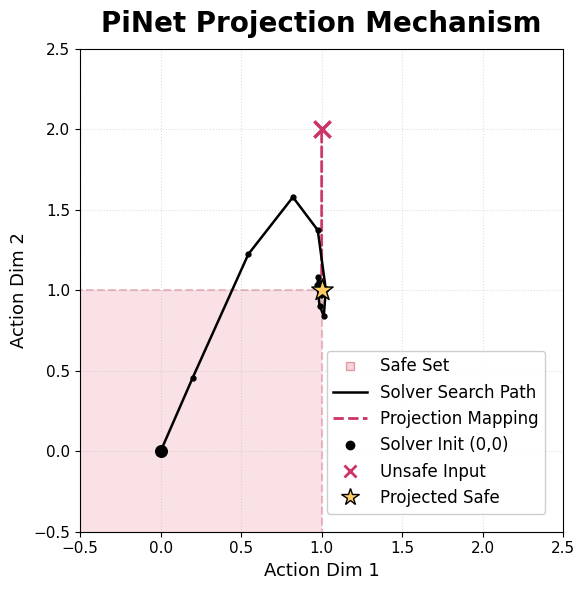

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, FancyArrowPatch
from matplotlib.lines import Line2D
from scipy.spatial import ConvexHull, HalfspaceIntersection
from scipy.optimize import linprog
from pathlib import Path

# ==========================================
# Geometry helper
# ==========================================

def get_polytope_polygon(A, b, interior_point=None):
    if isinstance(A, torch.Tensor): A = A.detach().cpu().numpy()
    if isinstance(b, torch.Tensor): b = b.detach().cpu().numpy()

    if A.ndim > 2: A = A[0]
    if b.ndim > 1: b = b[0]

    valid_mask = np.isfinite(b)
    A = A[valid_mask]
    b = b[valid_mask]

    if len(b) == 0:
        return None

    norm_A = np.linalg.norm(A, axis=1)
    c_obj = np.zeros(A.shape[1] + 1)
    c_obj[-1] = -1

    A_ub = np.hstack([A, norm_A[:, np.newaxis]])
    res = linprog(c_obj, A_ub=A_ub, b_ub=b, bounds=(None, None), method="highs")

    if res.success and res.x[-1] > 1e-6:
        interior_point = res.x[:-1]
    elif interior_point is None:
        interior_point = np.zeros(A.shape[1])

    halfspaces = np.hstack((A, -b[:, np.newaxis]))

    try:
        hs = HalfspaceIntersection(halfspaces, interior_point)
        vertices = hs.intersections
        hull = ConvexHull(vertices)
        ordered_vertices = vertices[hull.vertices]
        return Polygon(ordered_vertices, closed=True)
    except Exception:
        return None

# ==========================================
# Robust loader
# ==========================================

def load_list_data(filepath):
    path = Path(filepath)
    if not path.exists():
        for p in [Path("../" + path.name), Path(path.name)]:
            if p.exists():
                path = p
                break
        else:
            print(f"File not found: {filepath}")
            return None

    data = torch.load(path, map_location="cpu", weights_only=False)
    if not isinstance(data, list):
        data = [data]
    return data

# ==========================================
# Plot
# ==========================================

def plot_pinet_projection(filepath, step_idx=0, save=True):
    data_list = load_list_data(filepath)
    if not data_list:
        return

    data = data_list[min(step_idx, len(data_list)-1)]

    traj = data["trajectory"]
    unsafe = data["unsafe_action"]

    if traj.ndim == 3:
        traj = traj[:, 0, :]
    if unsafe.ndim == 2:
        unsafe = unsafe[0]

    traj = traj.detach().cpu().numpy()
    unsafe = unsafe.detach().cpu().numpy()

    start = traj[0]
    end = traj[-1]

    # --- Colors ---
    safe_fill = "#f3b6c2"
    safe_edge = "#cc6677"
    path_color = "black"
    proj_color = "#cc3366"
    unsafe_color = "#cc3366"
    projected_color = "#ffcc66"

    fig, ax = plt.subplots(figsize=(6, 6))

    # --- Safe set ---
    poly = get_polytope_polygon(data["safe_set_A"], data["safe_set_b"], interior_point=end)
    if poly:
        poly.set_facecolor(safe_fill)
        poly.set_edgecolor(safe_edge)
        poly.set_alpha(0.4)
        poly.set_linewidth(1.5)
        poly.set_linestyle("--")
        ax.add_patch(poly)

    # --- Path ---
    ax.plot(traj[:, 0], traj[:, 1], "-o", color=path_color, lw=1.8, markersize=3.5)

    # --- Projection arrow ---
    arrow = FancyArrowPatch(
        unsafe, end,
        arrowstyle="->",
        lw=2.0,
        linestyle="--",
        color=proj_color
    )
    ax.add_patch(arrow)

    # --- Points ---
    ax.scatter(start[0], start[1], c="black", s=70, zorder=3)
    ax.scatter(unsafe[0], unsafe[1], marker="x", c=unsafe_color, s=140, linewidths=2.5, zorder=4)
    ax.scatter(end[0], end[1], marker="*", c=projected_color, edgecolors="black", s=260, zorder=5)

    # --- Labels ---
    ax.set_title("PiNet Projection Mechanism", fontsize=20, fontweight="bold", pad=12)
    ax.set_xlabel("Action Dim 1", fontsize=13)
    ax.set_ylabel("Action Dim 2", fontsize=13)
    ax.tick_params(labelsize=11)

    ax.set_aspect("equal")
    ax.set_xlim(-0.5, 2.5)
    ax.set_ylim(-0.5, 2.5)

    ax.grid(True, linestyle=":", alpha=0.4)

    # --- Legend (bigger, and moved to avoid overlap) ---
    legend_elements = [
        Line2D([0],[0], marker='s', color='w', markerfacecolor=safe_fill, markeredgecolor=safe_edge, alpha=0.6, label='Safe Set'),
        Line2D([0],[0], color='black', lw=1.8, label='Solver Search Path'),
        Line2D([0],[0], color=proj_color, lw=2.0, linestyle='--', label='Projection Mapping'),
        Line2D([0],[0], marker='o', color='black', lw=0, label='Solver Init (0,0)'),
        Line2D([0],[0], marker='x', color=unsafe_color, lw=0, markersize=9, markeredgewidth=2, label='Unsafe Input'),
        Line2D([0],[0], marker='*', color=projected_color, markeredgecolor='black', lw=0, markersize=13, label='Projected Safe'),
    ]

    ax.legend(
        handles=legend_elements,
        loc="lower right",
        bbox_to_anchor=(0.98, 0.02),   # push legend further down-right
        fontsize=12,
        framealpha=0.95
    )

    # --- Layout ---
    plt.tight_layout()

    if save:
        plt.savefig("pinet_projection_clean.png", dpi=200, bbox_inches="tight")
        plt.savefig("pinet_projection_clean.svg", bbox_inches="tight")
        print("Saved:")
        print("  pinet_projection_clean.png")
        print("  pinet_projection_clean.svg")

    plt.show()

# ==========================================
# Run
# ==========================================

plot_pinet_projection("pinet5_steps_viz.pt", step_idx=0)
